# Multimodal Large Language Models

!["9.3"](img/9.3.png)

!["9.5"](img/9.5.png)

## Multimodal Embedding Models

!["9.11"](img/9.11.png)

### OpenCLIP

In [9]:
from urllib.request import urlopen
from PIL import Image

# Load an AI-generated image of a puppy playing in the snow
puppy_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/puppy.png"
image = Image.open(urlopen(puppy_path)).convert("RGB")
caption = "a puppy playing in the snow"

In [23]:
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

model_id = "openai/clip-vit-base-patch32"

# Load a tokenizer to preprocess the text
clip_tokenizer = CLIPTokenizerFast.from_pretrained(model_id)

# Load a processor to preprocess the images
clip_processor = CLIPProcessor.from_pretrained(model_id)

# Main model for generating text and image embeddings
model = CLIPModel.from_pretrained(model_id)

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:14: UserWarning: Failed to load image Python extension: 'Could not find module 'C:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks b

In [25]:
# Tokenize our input
inputs = clip_tokenizer(caption, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,   320,  6829,  1629,   530,   518,  2583, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [26]:
# Convert our input back to tokens
clip_tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

['<|startoftext|>',
 'a</w>',
 'puppy</w>',
 'playing</w>',
 'in</w>',
 'the</w>',
 'snow</w>',
 '<|endoftext|>']

In [27]:
# Create a text embedding
text_embedding = model.get_text_features(**inputs)
text_embedding.shape

torch.Size([1, 512])

In [28]:
# Preprocess image
processed_image = clip_processor(
    text=None, images=image, return_tensors='pt'
)['pixel_values']

processed_image.shape

torch.Size([1, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


(-0.5, 223.5, 223.5, -0.5)

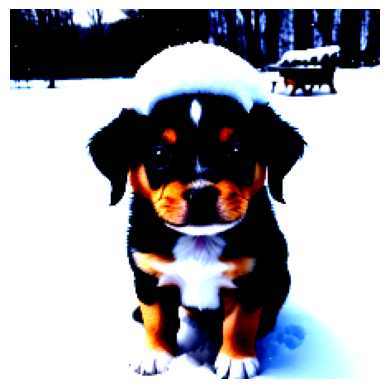

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Prepare image for visualization
img = processed_image.squeeze(0)
img = img.permute(*torch.arange(img.ndim - 1, -1, -1))
img = np.einsum('ijk->jik', img)

# Visualize preprocessed image
plt.imshow(img)
plt.axis('off')

In [30]:
# Create the image embedding
image_embedding = model.get_image_features(processed_image)
image_embedding.shape

torch.Size([1, 512])

In [31]:
# Normalize the embeddings
text_embedding /= text_embedding.norm(dim=-1, keepdim=True)
image_embedding /= image_embedding.norm(dim=-1, keepdim=True)

# Calculate their similarity
text_embedding = text_embedding.detach().cpu().numpy()
image_embedding = image_embedding.detach().cpu().numpy()
score = text_embedding @ image_embedding.T
score

array([[0.33149642]], dtype=float32)

### More Images

In [32]:
# Load an AI-generated image of a puppy playing in the snow
cat_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/cat.png"
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
paths = [puppy_path, cat_path, car_path]
images = [Image.open(urlopen(path)).convert("RGBA") for path in paths]
captions = [
    "a puppy playing in the snow",
    "a pixelated image of a cute cat",
    "A supercar on the road \nwith the sunset in the background"
]

import numpy as np

# Embed all images
image_embeddings = []
for image in images:
  image_processed = clip_processor(images=image, return_tensors='pt')['pixel_values']
  image_embedding = model.get_image_features(image_processed).detach().cpu().numpy()[0]
  image_embeddings.append(image_embedding)
image_embeddings = np.array(image_embeddings)

# Embed all captions
text_embeddings = []
for caption in captions:
  inputs = clip_tokenizer(caption, return_tensors="pt")
  text_emb = model.get_text_features(**inputs).detach().cpu().numpy()[0]
  text_embeddings.append(text_emb)
text_embeddings = np.array(text_embeddings)

In [33]:
# Calculate cosine similarity between images and captions
from sklearn.metrics.pairwise import cosine_similarity
sim_matrix = cosine_similarity(image_embeddings, text_embeddings)

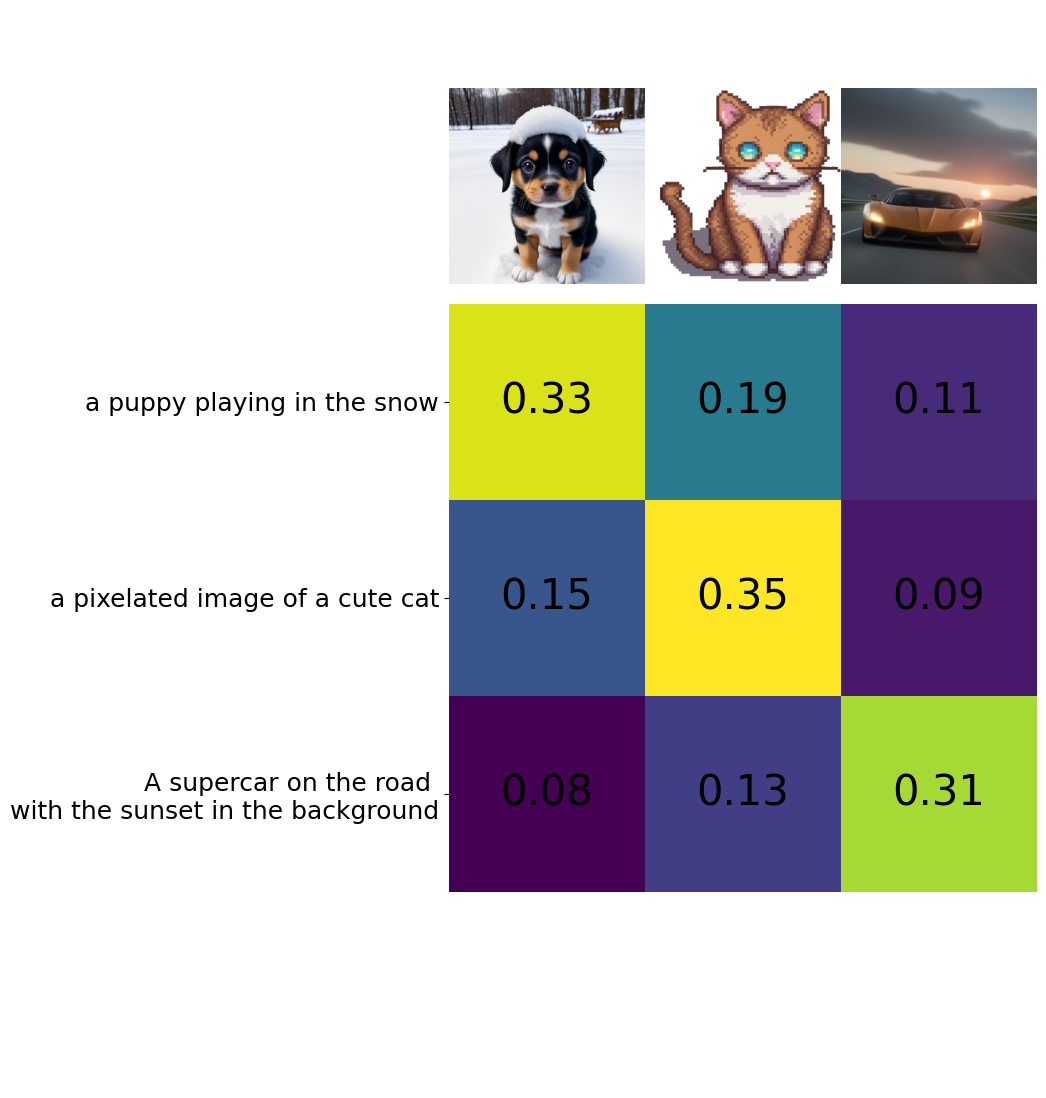

In [34]:
# Create base figure
plt.figure(figsize=(20, 14))
plt.imshow(sim_matrix, cmap='viridis')

# Adjust ticks with correct labels
plt.yticks(range(len(captions)), captions, fontsize=18)
plt.xticks([])

# Visualize
for i, image in enumerate(images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# Add the captions at the correct indices
for x in range(sim_matrix.shape[1]):
    for y in range(sim_matrix.shape[0]):
        plt.text(x, y, f"{sim_matrix[y, x]:.2f}", ha="center", va="center", size=30)

# Remove unnecessary spines
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

# Resize blocks
plt.xlim([-0.5, len(captions) - 0.5])
plt.ylim([len(captions) + 0.5, -2])
# plt.title("Similarity Matrix", size=20)
plt.savefig("sim_matrix.png", dpi=300, bbox_inches='tight')

!["six_matrix"](img/sim_matrix.png)

### SBERT

In [35]:
from sentence_transformers import SentenceTransformer, util

# Load SBERT-compatible CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# Encode the images
image_embeddings = model.encode(images)

# Encode the captions
text_embeddings = model.encode(captions)

#Compute cosine similarities
sim_matrix = util.cos_sim(image_embeddings, text_embeddings)
print(sim_matrix)

c:\Users\IdeaPad\anaconda3\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\IdeaPad\.cache\huggingface\hub\models--sentence-transformers--clip-ViT-B-32. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tensor([[0.3315, 0.1863, 0.1084],
        [0.1488, 0.3463, 0.0947],
        [0.0762, 0.1260, 0.3098]])


## Making Text Generation Models Multimodal

!["9.16"](img/9.16.png)

!["9.20"](img/9.20.png)

### BLIP-2

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

# Load processor and main model
blip_processor = AutoProcessor.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    # revision="51572668da0eb669e01a189dc22abe6088589a24"  # Choose specific model because of: https://huggingface.co/Salesforce/blip2-opt-2.7b/discussions/39
)
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    # revision="51572668da0eb669e01a189dc22abe6088589a24",
    torch_dtype=torch.float16
)

# Send the model to GPU to speed up inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [ ]:
# Load image of a supercar
car_path = "https://raw.githubusercontent.com/HandsOnLLM/Hands-On-Large-Language-Models/main/chapter09/images/car.png"
image = Image.open(urlopen(car_path)).convert("RGB")
image

In [ ]:
# Preprocess the image
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
inputs["pixel_values"].shape

In [ ]:
blip_processor.tokenizer

In [ ]:
# Preprocess the text
text = "Her vocalization was remarkably melodic"
token_ids = blip_processor(image, text=text, return_tensors="pt")
token_ids = token_ids.to(device, torch.float16)["input_ids"][0]

# Convert input ids back to tokens
tokens = blip_processor.tokenizer.convert_ids_to_tokens(token_ids)
tokens

In [ ]:
# Replace the space token with an underscore
tokens = [token.replace("Ġ", "_") for token in tokens]
tokens

### Use Case 1: Image Captioning

In [ ]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

# Convert an image into inputs and preprocess it
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
image

In [ ]:
# Generate image ids to be passed to the decoder (LLM)
generated_ids = model.generate(**inputs, max_new_tokens=20)

# Generate text from the image ids
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
# Load rorschach image
url = "https://upload.wikimedia.org/wikipedia/commons/7/70/Rorschach_blot_01.jpg"
image = Image.open(urlopen(url)).convert("RGB")

# Generate caption
inputs = blip_processor(image, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=20)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

### Use Case 2: Multimodal Chat-Based Prompting

In [ ]:
# Load an AI-generated image of a supercar
image = Image.open(urlopen(car_path)).convert("RGB")

# Visual Question Answering
prompt = "Question: Write down what you see in this picture. Answer:"

# Process both the image and the prompt
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

# Generate text
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
# Chat-like prompting
prompt = "Question: Write down what you see in this picture. Answer: A sports car driving on the road at sunset. Question: What would it cost me to drive that car? Answer:"

# Generate output
inputs = blip_processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
generated_ids = model.generate(**inputs, max_new_tokens=30)
generated_text = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)
generated_text = generated_text[0].strip()
generated_text

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets

def text_eventhandler(*args):
  question = args[0]["new"]
  if question:
    args[0]["owner"].value = ""

    # Create prompt
    if not memory:
      prompt = " Question: " + question + " Answer:"
    else:
      template = "Question: {} Answer: {}."
      prompt = " ".join(
          [
              template.format(memory[i][0], memory[i][1])
              for i in range(len(memory))
          ]
      ) + " Question: " + question + " Answer:"

    # Generate text
    inputs = blip_processor(image, text=prompt, return_tensors="pt")
    inputs = inputs.to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=100)
    generated_text = blip_processor.batch_decode(
        generated_ids,
        skip_special_tokens=True
    )
    generated_text = generated_text[0].strip().split("Question")[0]

    # Update memory
    memory.append((question, generated_text))

    # Assign to output
    output.append_display_data(HTML("<b>USER:</b> " + question))
    output.append_display_data(HTML("<b>BLIP-2:</b> " + generated_text))
    output.append_display_data(HTML("<br>"))

# Prepare widgets
in_text = widgets.Text()
in_text.continuous_update = False
in_text.observe(text_eventhandler, "value")
output = widgets.Output()
memory = []

# Display chat box
display(
    widgets.VBox(
        children=[output, in_text],
        layout=widgets.Layout(display="inline-flex", flex_flow="column-reverse"),
    )
)